# Anomaly Detection and Recommender Systems

## 1 Anomaly detection

"In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network."

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

Start with a 2D dataset (for ease of visualisation), using a Gaussian model to detect anomalies.

In [2]:
data = scipy.io.loadmat('data/ex8data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

We have unlabelled training set X, and labelled validation set [Xval, yval].

In [3]:
X = data['X']
X.shape

(307, 2)

307 examples of 2D data. "The features measure the throughput (mb/s) and latency (ms) of response of each server"

In [4]:
Xval = data['Xval']
yval = data['yval']

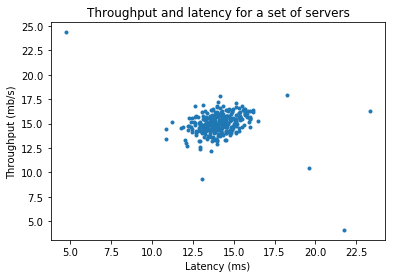

In [5]:
plt.scatter(X[:, 0], X[:, 1], marker='.')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Throughput and latency for a set of servers')
plt.show()

### 1.1 , 1.2 Gaussian distribution

In [6]:
def estimate_gaussian(X):
    '''
    Estimates the parameters of a Gaussian distribution using the data in X.

    Input:
        dataset X with one n-dimensional data point per row.
    Output:
        means mu, an n x 1 array,
        variances sigma^2, an n x 1 array.
    '''
    
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    
    return mu, sigma2

In [7]:
mu, sigma2 = estimate_gaussian(X)

In [8]:
# Find proability density for each point in X
p = scipy.stats.multivariate_normal(mu, sigma2).pdf(X)

In [9]:
# Visualise fit
xx0, xx1 = np.meshgrid(np.arange(0, 30, 0.5), np.arange(0, 30, 0.5))
Z = scipy.stats.multivariate_normal(mu, sigma2).pdf(np.c_[xx0.ravel(), xx1.ravel()])
Z = Z.reshape(xx0.shape)

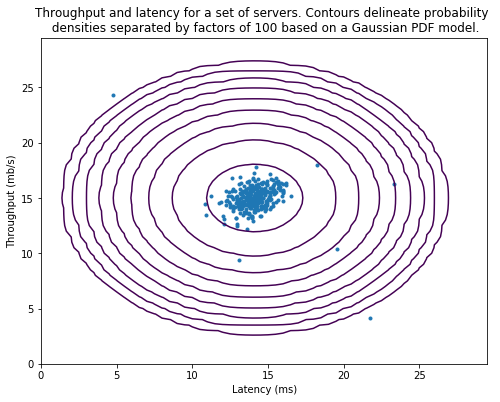

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], marker='.')
plt.contour(xx0, xx1, Z, np.logspace(-20, 0, 10))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Throughput and latency for a set of servers. Contours delineate probability \n densities separated by factors of 100 based on a Gaussian PDF model.')
plt.show()

We see that the vast majority of points are within the central (highest probability density) contour, and the small number of outliers are at *much* lower probability densities.

### 1.3 Selecting the threshold, ε

"In this part of the exercise, you will implement an algorithm to select the threshold ε using the F1 score on a cross validation set."

In [11]:
# y = 1 corresponds to an anomalous example, and y = 0 corresponds to a normal example

In [12]:
# Find probability densities of validation examples
pval = scipy.stats.multivariate_normal(mu, sigma2).pdf(Xval)

In [13]:
pred = pval < 8.9908527792694932e-05

In [14]:
def select_threshold(yval, pval):
    '''
    Finds the best threshold (epsilon) to use for selecting outliers
    based on the probability densities, pval, from a validation set
    and the ground truth for that validation set, yval.
    '''
    
    best_epsilon = 0
    best_F1 = 0

    yval = yval.flatten()
    
    stepsize = (max(pval) - min(pval)) / 1000
    for epsilon in np.arange(min(pval), max(pval), stepsize):
        # Logical array of predicted outliers
        pred = pval < epsilon
        
        # True positives
        tp = np.sum(np.logical_and(pred==1, yval==1))
        
        # False positives
        fp = np.sum(np.logical_and(pred==1, yval==0))
        
        # False negatives
        fn = np.sum(np.logical_and(pred==0, yval==1))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = 2 * precision * recall / (precision + recall)
    
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
    
    return best_epsilon, best_F1

In [15]:
epsilon, F1 = select_threshold(yval, pval)

/Users/robertseddon/anaconda/envs/numplot/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


I presume the warning is due to a divide by zero when epsilon==min(pval). In this situation we get no positives, which leads to precision = 0/0.

In [19]:
print('Best epsilon found using cross validation:', epsilon)
print('   (you should see a value epsilon of about 8.99e-05)')
print('Best F1 on cross validation set:', F1)
print('   (you should see a best F1 value of  0.875000)')

Best epsilon found using cross validation: 8.99085277927e-05
   (you should see a value epsilon of about 8.99e-05)
Best F1 on cross validation set: 0.875
   (you should see a best F1 value of  0.875000)
